In [1]:
import mne 
from glob import glob 
import os
import matplotlib 
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import numpy as np
import pandas as pd

In [2]:
#matplotlib.use('Qt5Agg') 

In [3]:
#quanti soggetti ho nella mia cartella?
subs_file_path=glob("..\..\DATASET PRINCIPALE\CartellaEEG/*.vhdr")
print(len(subs_file_path))

#creo vettore file excel---- !ATTENZIONE FAR RUNNARE IL FILE EXCEL.YPTR per aggiustare gli excel
excel_file_path=glob("..\..\DATASET PRINCIPALE\Cartellaexcel/*.xlsx")
print(len(excel_file_path))

1
1


In [4]:
#Creo la funzione che legge e processa i dati 
def prep_data(file_path):
    data= mne.io.read_raw_brainvision(file_path, preload=True)
    data.set_eeg_reference();                                                    #riferimento rispetto alla media
    data.notch_filter(np.arange(10,70,10), filter_length='auto',phase='zero')    #tolta frequenza di rete e ESSVP
    data.filter(l_freq=0.1,h_freq=12, filter_length='auto', method='iir')                                            #banda passante
    data.resample(250)                                                           #diminuzione dati
    return data

#Creo la funzione che estrae la matrice delle annotazioni dai file excel 
def get_vectors(data_path):

    book=load_workbook(data_path)
    sheet=book.active
    
    #onset
    onset=[]
    for row in sheet['a2':'a22249']:
        for cel in row:
               onset.append(cel.value)
                
    onset=np.array(onset)
    onset=onset*0.001
    
    #duration 
    duration=np.ones((22248,), dtype=int)*0.01
    
    #description 
    animal=['animal']
    human=['human']
    food=['food']
    vehicles=['vehicles']
    tools=['tools']
    description=[]
    for row in sheet ['e2':'e22249']:
        for cel in row:
            if(cel.value in animal):
                description.append(cel.value)
            elif(cel.value in human):
                description.append(cel.value)
            elif(cel.value in food):
                description.append(cel.value)
            elif(cel.value in vehicles):
                description.append(cel.value)
            elif(cel.value in tools):
                description.append(cel.value)
            else:
                description.append('E 1')
    return [onset, duration, description] 

#creo la funzione che applica le annotazioni 
def fix_events(data_vector, matrix):
    myannot=[mne.Annotations(onset=matrix[i][0], duration=matrix[i][1],description=matrix[i][2])for i in range(len(excel_file_path))]
    for i in range(len(excel_file_path)):
        data_vector[i].set_annotations(myannot[i])
    
    return data_vector

#creo la funzione che estrae le epochs
def get_epochs(data):
    tmin=-0.100                   #partono 100 millisecondi prima di un evento 
    tmax=0.5                      #finiscon 500 milli secondo dopo (come da paper dataset, per prendere tutte le latenze ERP)
    baseline=(None,0)
    epochs=mne.Epochs(data,events=mne.events_from_annotations(data)[0] ,tmin=tmin,tmax=tmax,baseline=baseline, preload=True)
    #reject  bad epochs
    reject_criteria = dict(eeg=150e-6)
    flat_criteria = dict(eeg=1e-6)
    epochs.drop_bad(reject=reject_criteria, flat=flat_criteria)

    return epochs

def prep_data_ica(file_path):
    data= mne.io.read_raw_brainvision(file_path, preload=True)
    data.set_eeg_reference();                                                  #riferimento rispetto alla media
    data.notch_filter(np.arange(10,60,10), filter_length='auto',phase='zero')  #tolta frequenza di rete e ESSVP
    data.resample(250)                                                         #diminuzione dati
    return data

In [5]:
#funzione preprocessing
prep_data_sub_vector= [prep_data(i)for i in subs_file_path]

Extracting parameters from ..\..\DATASET PRINCIPALE\CartellaEEG\sub-01_task-rsvp_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3035739  =      0.000 ...  3035.739 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 12.00 Hz: -6.02, -6.02 dB



In [6]:
#estraggo la matrice delle annotazioni 
matrix=[]
for i in range(len(excel_file_path)):
    matrix=[get_vectors(i)for i in excel_file_path]
    
#sistemo gli eventi 
data_vector_ok= fix_events(prep_data_sub_vector, matrix)

#ICA
#applico la ica per visualizzare i picchi di potenza da rimuovere
raw_ica = [prep_data_ica(i) for i in subs_file_path]

ica = mne.preprocessing.ICA(n_components=0.99999, max_iter=1000,random_state=42)
raw_list= [i.filter(1, 50) for  i in raw_ica ]

Extracting parameters from ..\..\DATASET PRINCIPALE\CartellaEEG\sub-01_task-rsvp_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3035739  =      0.000 ...  3035.739 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband e

In [7]:
#per sistemare il codice bisogna creare nomi1 con i soggetti precedenti al primo di nomi2

ica.fit(raw_list[0])
bad_idx, scores=ica.find_bads_eog(raw_ica[0],ch_name=['Fp1','Fp2'],threshold=1)
ica.exclude=bad_idx
data_vector_ok[0]=ica.apply(data_vector_ok[0], exclude=ica.exclude)



Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by explained variance: 59 components
Fitting ICA took 68.1s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition ba

In [8]:
#chiamo la funzione che crei le epochs e le salvi nei file fif
epochs_vector=[get_epochs(i)for i in data_vector_ok]

Used Annotations descriptions: ['E 1', 'animal', 'human']
Not setting metadata
Not setting metadata
22248 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22248 events and 151 original time points ...
0 bad epochs dropped
0 bad epochs dropped


In [9]:
epochs=epochs_vector[0]
len(epochs)

22248

In [10]:
print(len(epochs['10001']))
print(len(epochs['10002']))
print(len(epochs['10003']))

20484
1308
456


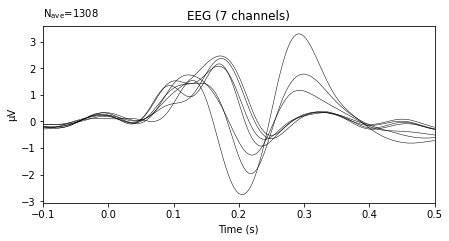

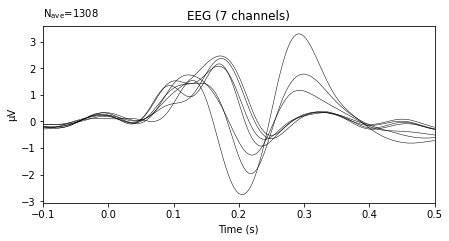

In [11]:
epochs['10002'].average(picks=[15,17,16,45,46,48,47]).plot()

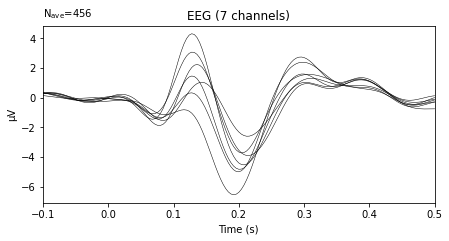

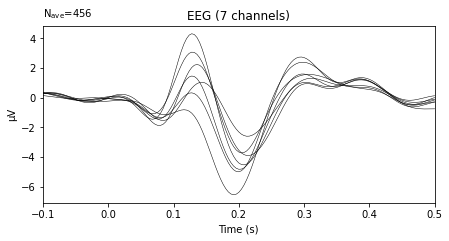

In [12]:
epochs['10003'].average(picks=[15,17,16,45,46,48,47]).plot()

In [13]:
#10002 e 10004 --> 0.74% acc 
epochs_a=epochs['10002'].get_data(picks=[15,17,16,45,46,48,47])
epochs_u=epochs['10003'].get_data(picks=[15,17,16,45,46,48,47])


print(epochs_a.shape)
print(epochs_u.shape)

(1308, 7, 151)
(456, 7, 151)


In [14]:
ev=epochs_a.average()

AttributeError: 'numpy.ndarray' object has no attribute 'average'

In [ ]:
EV_a=np.mean(epochs_a, axis=1)
EV_u=np.mean(epochs_u, axis=1)

##############################
print(EV_a.shape)
print(EV_u.shape)


In [ ]:
x=np.linspace(-100,500,151)

In [ ]:
x[110]

In [ ]:
#crop
EV_a= [np.delete(EV_a[i,:],np.concatenate((np.arange(0,25,1),np.arange(110,151,1)))) for i in range(456)]
EV_u= [np.delete(EV_u[i,:],np.concatenate((np.arange(0,25,1),np.arange(110,151,1)))) for i in range(len(EV_u))]

EV_a[0].shape

In [ ]:
x=np.linspace(0,x[110],85)
figure, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

axes[0, 0].set_title('Amali')
axes[0, 1].set_title('Uomini')
for  i in range(5):
    axes[i, 0].plot(x,EV_a[i])
    axes[i, 1].plot(x,EV_u[i]) 

In [ ]:
#PROVO LA CWT 
import pywt

cwt_animali_vector=[pywt.cwt(i,np.arange(1,15),'morl')for i in EV_a]
cwt_uomini_vector =[pywt.cwt(i,np.arange(1,15),'morl')for i in EV_u]

In [ ]:
cwt_animali_vector[0][0].shape

In [ ]:
Features_a=[cwt_animali_vector[i][0].flatten() for  i in range(len(EV_a))]
Features_u=[cwt_uomini_vector[i][0].flatten() for  i in range(len(EV_u)) ]

In [ ]:
df1 = pd.DataFrame (Features_a)
df2 = pd.DataFrame (Features_u)
frames = [df1, df2]
features = pd.concat(frames)

In [ ]:
#LABELS 
a_type=np.zeros(456, dtype=int)
b_type=np.ones(456, dtype=int)
labels=np.concatenate((a_type,b_type))

In [ ]:
#applico PCA
from sklearn.preprocessing import StandardScaler
df=StandardScaler().fit_transform(features) 

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc 1','pc 2'])

In [ ]:
#CON PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
clf = svm.SVC(kernel='rbf', C=1)
splitter=KFold(n_splits=10, shuffle=True)
scores = cross_val_score(clf, principalDf, labels, cv=splitter)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))

In [ ]:
#SENZA PCA 
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
clf = svm.SVC(kernel='rbf', C=1)
splitter=KFold(n_splits=10, shuffle=True)
scores = cross_val_score(clf, features, labels, cv=splitter)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))

In [ ]:
def SVM_traintest(labels, features,combinazioni):
    features_train, features_test, labels_train, labels_test = train_test_split(features,labels, test_size=0.3)
    sc_X = StandardScaler()
    features_train = sc_X.fit_transform(features_train)
    features_test = sc_X.fit_transform(features_test)
    clf=OneVsRestClassifier(svm.SVC(kernel='rbf'))
    clf.fit(features_train, labels_train)
    labels_pred=clf.predict(features_test)
    print('ACCURATEZZA', combinazioni) 
    print(accuracy_score(labels_test, labels_pred))
    cm = confusion_matrix(labels_test, labels_pred, labels=clf.classes_)
    sns.heatmap(cm, annot=True)
    plt.savefig('confusion.png')
    print(classification_report(labels_test, labels_pred))
    return [accuracy_score(labels_test, labels_pred),cm]

In [ ]:
combinazioni=['Animali-Uomini, intertrial']
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
SVM_traintest(labels,features,combinazioni)

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
clf = svm.SVC(kernel='rbf', C=1)
splitter=KFold(n_splits=10, shuffle=True)
scores = cross_val_score(clf, features, labels, cv=splitter)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))